In [2]:
import os
from IPython import display
from matplotlib import pyplot as plt
import rasterio
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import sklearn
import math
import time
from zipfile import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\thesis\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\thesis\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\thesis\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

In [3]:
import sys
sys.path.append('../')
from CPR.configs import data_path
from CPR.utils import tif_stacker, cloud_generator, preprocessing, train_val

In [283]:
import importlib
importlib.reload(CPR.utils)

<module 'CPR.utils' from '..\\CPR\\utils.py'>

In [4]:
# Order in which features should be stacked to create stacked tif
feat_list_new = ['aspect','curve', 'developed', 'GSW_distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

img_list = ['4115_LC08_021033_20131227_test']

for j, img in enumerate(img_list):
    #  Stack all the flood imagery
    tif_stacker(data_path, img, feat_list_new, overwrite=False)
    cloud_generator(img, data_path, overwrite=False)


"stack.tif" already exists for 4115_LC08_021033_20131227_test
Cloud image already exists for 4115_LC08_021033_20131227_test


In [10]:
pctl = [20]
data_train, data_vector_train, data_ind_train = preprocessing(data_path, img, pctl, gaps=False)
training_data, validation_data = train_val(data_vector_train, holdout=0.3)

## Training NN with MC Dropout 

In [16]:
X_train, y_train = training_data[:,0:14], training_data[:,14]
X_val, y_val = validation_data[:,0:14], validation_data[:,14]

pctl = 20
INPUT_DIMS = X_train.shape[1:]
INPUT_SIZE = X_train.shape[0]
BATCH_SIZE = 2000
EPOCHS = 100
DROPOUT_RATE = 0.3
HOLDOUT = 0.3

In [30]:
# Using Functional API
## def get_NN_MCD():
#     inputs = tf.keras.layers.Input(shape=(input_dims,))
#     x = tf.keras.layers.Dropout(rate=dropout_rate)(inputs, training=True)
#     x = tf.keras.layers.Dense(units=29, activation='relu')(x)
#     x = tf.keras.layers.Dropout(rate=dropout_rate)(x, training=True)  
#     x = tf.keras.layers.Dense(units=15, activation='relu')(x)
#     outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',      
# #                   metrics=[tf.keras.metrics.Recall()])
# #                   metrics=[tf.keras.metrics.F1()])
#                   metrics=['sparse_categorical_accuracy'])
#     return model

# Using Sequential API
def get_NN_MCD():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=INPUT_DIMS)),
    model.add(tf.keras.layers.Lambda(lambda x: K.dropout(x, level=DROPOUT_RATE))),
    model.add(tf.keras.layers.Dense(units=29,
                                    activation='relu')),
    model.add(tf.keras.layers.Lambda(lambda x: K.dropout(x, level=DROPOUT_RATE))),
    model.add(tf.keras.layers.Dense(units=15,
                                    activation='relu')),
#     model.add(tf.keras.layers.Dropout(rate=dropout_rate)(training=True)),
#     model.add(tf.keras.layers.Flatten()),
    model.add(tf.keras.layers.Dense(2,
                                    activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',      
#                   metrics=[tf.keras.metrics.Recall()])
#                   metrics=[tf.keras.metrics.F1()])
                  metrics=['sparse_categorical_accuracy'])
    return model

# Can maybe use callbacks to get output? https://keras.io/callbacks/

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.5, patience=10, verbose=1)

NN_MCD = get_NN_MCD()
NN_MCD.summary()
NN_MCD.fit(X_train, y_train,
           batch_size = BATCH_SIZE,
           epochs= EPOCHS,
           verbose = 1,
           validation_data = (X_val, y_val),
           callbacks = [es],
           use_multiprocessing = True)
# model_path = data_path / 'models' / 'cnn_vary_clouds' / img / '{0}'.format(img+'_clouds_'+str(pctl)+'.h5')
# NN_MCD.save(model_path)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_28 (Lambda)           (None, 14)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 29)                435       
_________________________________________________________________
lambda_29 (Lambda)           (None, 29)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 15)                450       
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 32        
Total params: 917
Trainable params: 917
Non-trainable params: 0
_________________________________________________________________
Train on 221269 samples, validate on 94829 samples
Epoch 1/100
221269/221269 [==============================] - 1s 7us/sa

In [275]:
# This is from my S.O. question - the solution doesn't seem to produce the same output as 
# is produced during training though

# def get_model(training=None):
#     inputs = tf.keras.layers.Input(shape=(input_dims,))
#     x = tf.keras.layers.Dropout(rate=dropout_rate)(inputs, training=training)
#     x = tf.keras.layers.Dense(units=29, activation='relu')(x)
#     x = tf.keras.layers.Dropout(rate=dropout_rate)(x, training=training)  
#     x = tf.keras.layers.Dense(units=15, activation='relu')(x)
#     outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',      
# #                   metrics=['sparse_categorical_accuracy'])
#                   metrics=['accuracy'])                  
#     return model

# # build a model with dropout layers active in both training and test phases
# myModel = get_model(training=True)
# # train the model
# myModel.fit(X_train, y_train,
#             batch_size = BATCH_SIZE,
#             epochs= EPOCHS,
#             verbose = 1,
#             validation_data = (X_val, y_val),
#             use_multiprocessing = False)

# # build a clone of the model with dropouts deactivated in test phase
# myTestModel = get_model(training=False)  # note: the `training` is `None` by default
# # transfer the weights from the trained model to this model
# myTestModel.set_weights(myModel.get_weights())
# # use the new model in test phase; the dropouts would not be active
# preds = myTestModel.predict(X_train)
# sklearn.metrics.accuracy_score(y_train, np.argmax(preds, axis=1))

Train on 28051 samples, validate on 12022 samples
Epoch 1/4
28051/28051 [==============================] - 2s 57us/sample - loss: 0.3271 - acc: 0.9390 - val_loss: 0.1727 - val_acc: 0.9939
Epoch 2/4
28051/28051 [==============================] - 0s 11us/sample - loss: 0.1397 - acc: 0.9880 - val_loss: 0.0869 - val_acc: 0.9949
Epoch 3/4
28051/28051 [==============================] - 0s 12us/sample - loss: 0.0906 - acc: 0.9887 - val_loss: 0.0559 - val_acc: 0.9953
Epoch 4/4
28051/28051 [==============================] - 0s 10us/sample - loss: 0.0702 - acc: 0.9898 - val_loss: 0.0449 - val_acc: 0.9956


0.9921927917008306

## Testing NN on cloud gaps

In [107]:
pctl = [20]
data_gaps, data_vector_gaps, data_ind_gaps = preprocessing(data_path, img, pctl, gaps=True)

X_test, y_test = data_vector_gaps[:,0:14], data_vector_gaps[:,14]

def predict_with_uncertainty(model, X):
    preds = []
    for i in range(mc_passes):
        preds.append(model.predict(X))
    preds = np.array(preds)
    means = np.mean(preds, axis=0)
    variances = np.var(preds, axis=0)
    stds = np.std(preds, axis=0)
    pred = np.argmax(means, axis=1)
    
#     return pred, preds, means, variances, stds
    return pred, variances

mc_passes = 100
# pred, preds, means, variances, stds = predict_with_uncertainty(NN_MCD, X_test)
pred, variances = predict_with_uncertainty(NN_MCD, X_test)

In [ ]:
# Plotting how many MC samples predicted flooding?
# (# times the prob of flooding > 0.5) / # samples
# The color bar should be more saturated in the middle to highlight greater
# uncertainty, and lighter towards 0% and 100%.

# flood = 0
# flood += 

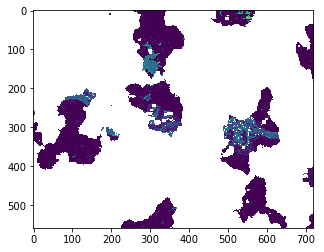

In [126]:
# Reshape gaps back into image
stack_path = data_path / 'images' / img / 'stack' / 'stack.tif'
with rasterio.open(str(stack_path), 'r') as ds:
        shape = ds.read(1).shape # Shape of full original image
        arr_empty = np.zeros(shape) # Create empty array with this shape
        arr_empty[:] = np.nan # Convert all zeroes to NaN
        var_img = arr_empty
        rows, cols = zip(data_ind_gaps)
        var_img[rows, cols] = variances[:,0]
plt.imshow(var_img)

## Training NN on multiple images and cloud covers

In [34]:
def get_NN_MCD():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=INPUT_DIMS)),
    model.add(tf.keras.layers.Lambda(lambda x: K.dropout(x, level=DROPOUT_RATE))),
    model.add(tf.keras.layers.Dense(units=29,
                                    activation='relu')),
    model.add(tf.keras.layers.Lambda(lambda x: K.dropout(x, level=DROPOUT_RATE))),
    model.add(tf.keras.layers.Dense(units=15,
                                    activation='relu')),
#     model.add(tf.keras.layers.Dropout(rate=dropout_rate)(training=True)),
#     model.add(tf.keras.layers.Flatten()),
    model.add(tf.keras.layers.Dense(2,
                                    activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',      
#                   metrics=[tf.keras.metrics.Recall()])
#                   metrics=[tf.keras.metrics.F1()])
                  metrics=['sparse_categorical_accuracy'])
    return model

In [35]:
import sys
sys.path.append('../')
from CPR.configs import data_path
from CPR.utils import tif_stacker, cloud_generator, preprocessing, train_val, timer

# Order in which features should be stacked to create stacked tif
feat_list_new = ['aspect','curve', 'developed', 'GSW_distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

# Image to predict on
# img_list = ['4115_LC08_021033_20131227_test']
img_list = ['4101_LC08_027038_20131103_1']
#             '4101_LC08_027038_20131103_2' 
#             '4101_LC08_027039_20131103_1',
#             '4115_LC08_021033_20131227_1',
#             '4337_LC08_026038_20160325_1']

pctls = [10,20,30,40,50,60,70,80,90]
# pctls = [40, 50]
batch_size = 7000
epochs = 100
dropout_rate = 0.3
holdout = 0.3 # Validation data size
cb_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 min_delta=0.5, 
                                                 patience=10, 
                                                 verbose=1)]
valMetricsList = []

# Stack layers into a single tif, and generate cloud cover image
for j, img in enumerate(img_list):
    precision = []
    recall = []
    f1 = []
    accuracy = []
    times = []
    history = []
    
    tif_stacker(data_path, img, feat_list_new, overwrite=False)
    cloud_generator(img, data_path, overwrite=False)
    
    for i, pctl in enumerate(pctls):
        data_train, data_vector_train, data_ind_train = preprocessing(data_path, img, pctl, gaps=False)
        training_data, validation_data = train_val(data_vector_train, holdout=holdout)
        X_train, y_train = training_data[:,0:14], training_data[:,14]
        X_val, y_val = validation_data[:,0:14], validation_data[:,14]
        INPUT_DIMS = X_train.shape[1]
                           
        print('~~~~~', img, pctl+'% cloud cover')
        
        NN_MCD = get_NN_MCD()
        start_time = time.time()
        
        NN_MCD.fit(X_train, y_train,
                   batch_size = batch_size,
                   epochs= epochs,
                   verbose = 2,
                   validation_data = (X_val, y_val),
                   callbacks=cb_list,
                   use_multiprocessing = True)
        
        end_time = time.time()
        times.append(timer(start_time, end_time, False))

        model_path = data_path / 'models' / 'cnn_vary_clouds' / img / '{0}'.format(img+'_clouds_'+str(pctl)+'.h5')
        NN_MCD.save(model_path)
    
    metrics_path = data_path / 'metrics' / 'testing' / img 
    
    try:
        metrics_path.mkdir(parents=True)
    except FileExistsError:
        print('Metrics directory already exists')
    
    times = [float(i) for i in times]
    times_df = pd.DataFrame(times, columns = ['times'])
    times_df.to_csv(metrics_path / 'training_times.csv', index=False)
    

"stack.tif" already exists for 4101_LC08_027038_20131103_1
Cloud image already exists for 4101_LC08_027038_20131103_1
4101_LC08_027038_20131103_1
Train on 8006443 samples, validate on 3431333 samples
Epoch 1/100
8006443/8006443 - 26s - loss: 0.0821 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.0305 - val_sparse_categorical_accuracy: 0.9964
Epoch 2/100
8006443/8006443 - 24s - loss: 0.0433 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.0470 - val_sparse_categorical_accuracy: 0.9926
Epoch 3/100
8006443/8006443 - 24s - loss: 0.0391 - sparse_categorical_accuracy: 0.9883 - val_loss: 0.0864 - val_sparse_categorical_accuracy: 0.9708
Epoch 4/100
8006443/8006443 - 24s - loss: 0.0373 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.1515 - val_sparse_categorical_accuracy: 0.9267
Epoch 5/100
8006443/8006443 - 23s - loss: 0.0364 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.2036 - val_sparse_categorical_accuracy: 0.8977
Epoch 6/100
8006443/8006443 - 25s - loss: 0.0354 - sparse_ca

Epoch 8/100
4406035/4406035 - 14s - loss: 0.0303 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.0464 - val_sparse_categorical_accuracy: 0.9875
Epoch 9/100
4406035/4406035 - 15s - loss: 0.0301 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.0474 - val_sparse_categorical_accuracy: 0.9871
Epoch 10/100
4406035/4406035 - 14s - loss: 0.0296 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.0469 - val_sparse_categorical_accuracy: 0.9875
Epoch 11/100
4406035/4406035 - 15s - loss: 0.0296 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.0489 - val_sparse_categorical_accuracy: 0.9867
Epoch 00011: early stopping
4101_LC08_027038_20131103_1
Train on 3521240 samples, validate on 1509102 samples
Epoch 1/100
3521240/3521240 - 12s - loss: 0.0765 - sparse_categorical_accuracy: 0.9856 - val_loss: 0.0434 - val_sparse_categorical_accuracy: 0.9879
Epoch 2/100
3521240/3521240 - 11s - loss: 0.0376 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.0395 - val_sparse_categorical_accuracy: 0.9889


## Testing

In [36]:
# There is a problem loading keras models: https://github.com/keras-team/keras/issues/10417
# But loading the weights into an identical compiled model works

import pickle

def predict_with_uncertainty(model, X):
    preds = []
    for i in range(MC_PASSES):
        if i % 10 == 0 or i == MC_PASSES - 1:
            print('Running MC '+str(i)+'/'+str(MC_PASSES))
        preds.append(model.predict(X, batch_size=7000, use_multiprocessing=True))
    preds = np.array(preds)
    means = np.mean(preds, axis=0)
    variances = np.var(preds, axis=0)
    stds = np.std(preds, axis=0)
    pred = np.argmax(means, axis=1)
    pred = list(pred)
#     return pred, preds, means, variances, stds
    return pred, variances

MC_PASSES = 100

for j, img in enumerate(img_list):
    precision = []
    recall = []
    f1 = []
    accuracy = []
    times = []
    predictions = []
    gapMetricsList = []
    variances = []
    
    for i, pctl in enumerate(pctls):
        data_test, data_vector_test, data_ind_test = preprocessing(data_path, img, pctl, gaps=True)
        X_test, y_test = data_vector_test[:,0:14], data_vector_test[:,14]
        
        print(img, pctl)
        
        start_time = time.time()
        NN_MCD = get_NN_MCD() # Get untrained model to add trained weights into
        model_path = data_path / 'models' / 'cnn_vary_clouds' / img / '{0}'.format(img+'_clouds_'+str(pctl)+'.h5')
        NN_MCD.load_weights(str(model_path))
        preds, variances = predict_with_uncertainty(NN_MCD, X_test)
        
        times.append(timer(start_time, time.time(), False)) # Elapsed time for MC simulations
        predictions.append(list(preds))
        accuracy.append(sklearn.metrics.accuracy_score(y_test, preds))
        precision.append(sklearn.metrics.precision_score(y_test, preds))
        recall.append(sklearn.metrics.recall_score(y_test, preds))
        f1.append(sklearn.metrics.f1_score(y_test, preds))
    
    metrics_path = data_path / 'metrics' / 'testing' / img 
    
    try:
        metrics_path.mkdir(parents=True)
    except FileExistsError:
        print('Metrics directory already exists')
        
    with open(str(metrics_path / 'predictions.pkl'), 'wb') as outfile:
        pickle.dump(predictions, outfile, pickle.HIGHEST_PROTOCOL)

    times = [float(i) for i in times] # Need to convert time objects to float, otherwise valMetrics will be non-numeric
        
    gapMetrics = pd.DataFrame(np.column_stack([pctls, accuracy, precision, recall, f1, times]),
                          columns=['cloud_cover','accuracy','precision','recall','f1', 'time'])
    
    gapMetrics.to_csv(metrics_path / 'gapMetrics.csv', index=False)


4101_LC08_027038_20131103_1 10
Running MC 0/100
Running MC 10/100
Running MC 20/100
Running MC 30/100
Running MC 40/100
Running MC 50/100
Running MC 60/100
Running MC 70/100
Running MC 80/100
Running MC 90/100
Running MC 99/100
4101_LC08_027038_20131103_1 20
Running MC 0/100
Running MC 10/100
Running MC 20/100
Running MC 30/100
Running MC 40/100
Running MC 50/100
Running MC 60/100
Running MC 70/100
Running MC 80/100
Running MC 90/100
Running MC 99/100
4101_LC08_027038_20131103_1 30
Running MC 0/100
Running MC 10/100
Running MC 20/100
Running MC 30/100
Running MC 40/100
Running MC 50/100
Running MC 60/100
Running MC 70/100
Running MC 80/100
Running MC 90/100
Running MC 99/100
4101_LC08_027038_20131103_1 40
Running MC 0/100
Running MC 10/100
Running MC 20/100
Running MC 30/100
Running MC 40/100
Running MC 50/100
Running MC 60/100
Running MC 70/100
Running MC 80/100
Running MC 90/100
Running MC 99/100
4101_LC08_027038_20131103_1 50
Running MC 0/100
Running MC 10/100
Running MC 20/100
Runn

KeyboardInterrupt: 

In [371]:
# Look into using GPU to improve speed
# Also callbacks like EarlyStopping to halt training once performance stops improving